<a href="https://colab.research.google.com/github/Myrto-Iglezou/AI2-project3/blob/master/Best-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YΣ19 Artificial Intelligence II
# Homework 3

### Iglezou Myrto - 111520170038

# Best Model

In [1]:
import pandas as pd 
from pandas import DataFrame, read_csv

Download the dataset.

In [2]:
import gdown
url = 'https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
output = "twitterData.csv"
gdown.download(path, output, quiet=True)
twitterData = pd.read_csv("/content/twitterData.csv",nrows=50000)
df = pd.DataFrame(data=twitterData)
df.head(5)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


Creating a new dataframe with only two columns, target and text.


In [3]:
df.drop(df.columns.difference(['text','target']), 1, inplace=True)
df['target'].replace({4: 1}, inplace = True)
df.head(5)

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,1,A @ 415 B @ 425. Tell your bro i say congrats!
3,1,@littlefluffycat Indeed.
4,1,Completed Race 4 Life in 58mins with girlies f...


## Data pre-processing

### Removing the scpecial characters

In [4]:
import re

def RemoveSpecialCharacters(x):
    x = re.sub(r'[^\w]+', " ", x)
    return x

In [5]:
df['text'] = df['text'].apply(lambda x: RemoveSpecialCharacters(x) )

### Lemmatize

In [6]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

df['text'] = df['text'].apply(lambda x: WordNetLemmatizer().lemmatize(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Removing the upercase

In [7]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [8]:
df.head(5)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,completed race 4 life in 58mins with girlies f...


## Training on GPU

In [9]:
import torch
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


## Word embedding - GloVe
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [10]:
from torchtext.vocab import GloVe
glove = GloVe(name='twitter.27B', dim=25)

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:42, 2.16MB/s]                            
100%|█████████▉| 1192716/1193514 [00:23<00:00, 53322.49it/s]

In [11]:
from torchtext.data import Field
text_field = Field(sequential=True,tokenize='spacy',fix_length=100)

label_field = Field(sequential=False, use_vocab=False)
preprocessed_text = df['text'].apply(lambda x: text_field.preprocess(x)) #apply preprocess manually
text_field.build_vocab(preprocessed_text, vectors=glove)  # load embedding with 25d
vocab = text_field.vocab  # get the vocab instance

### Create the datasets

We have train, validation and test datasets that contain text and label information. Train has 80%, validation 10% and test 10%.

In [12]:
from torchtext.data import Dataset, Example
fields = (('target', label_field),('text', text_field))
train_dataset, valid_dataset, test_dataset= Dataset(examples=[Example.fromlist(list(r), fields)
                                               for i, r in df.iterrows()],
                                               fields = fields).split(split_ratio = [0.8, 0.1, 0.1])

100%|█████████▉| 1192716/1193514 [00:40<00:00, 53322.49it/s]

## Batching sentences together 
Use *BucketIterator* to create the batches for the 3 datasets with batch size 64.

In [13]:
from torchtext.data import BucketIterator
train_iter, valid_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, valid_dataset, test_dataset),
                                                          batch_sizes=(64,64,64), sort=False,device = 'cuda' if train_on_gpu else 'cpu')

## Architecture of RNN

In [14]:
import torch.nn as nn
import numpy as np
from numpy import zeros

In [15]:
class GRUclassifier(nn.Module):
    """
    Wrapper module for RNN, LSTM, GRU cells using pytorch api. 
    The output is fed to a FFN for classification.
    """
    def __init__(self,embedding, input_size, output_size,embedding_dim = 25, \
                 hidden_size=100, num_layers=1, bidirectional=False, dropout = 0):
        super(GRUclassifier, self).__init__()
        
        # Initializations
        self.embedding = embedding
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        self.input_size, self.hidden_size, self.num_layers, self.output_size = input_size, hidden_size, num_layers, output_size
        self.bidirectional = bidirectional
        self.sigmoid = nn.Sigmoid()
        self.rnn = nn.GRU(         # Pick the specific model
            input_size=embedding_dim,           # Number of features for each time step
            hidden_size=hidden_size,         # Rnn hidden embedding representation
            num_layers=num_layers,           # Number of layers (if >1 it is a stacked RNN)
            dropout=dropout,
            bidirectional=bidirectional, # If true it is a 
            batch_first=True,       # input & output will have batch size as 1st dimension. e.g. (batch, time_step, input_size)
        )
        
        if bidirectional: # we'll have 2 more layers as the output to the final layer
            self.out = nn.Linear(hidden_size * 2, output_size)
        else:
            self.out = nn.Linear(hidden_size, output_size)
            
    def forward(self, x, prints=False):

        x = self.embedding[x]

        if train_on_gpu:
          x = x.cuda()

        r_out, last_hidden_state = self.rnn(x.detach())
      
        r_out = r_out[:, -1, :]

        out = self.out(r_out)

        out = self.dropout(out)

        return self.sigmoid(out)

In [16]:
def train(model,X,y,optimizer,loss_fn):

    if train_on_gpu:
      X, y = X.cuda(), y.cuda()

# step 1. Zero the gradients
    optimizer.zero_grad()
# step 2. Compute the output
    y_pred = model(X)

    if train_on_gpu:
      y_pred = y_pred.squeeze().cuda()
    else:
      y_pred = y_pred.squeeze()
# step 3. Compute the loss
    loss = loss_fn(y_pred, y)
# step 4. use loss to produce gradients
    loss.backward()
# step 5. use optimizer to take gradient step
    optimizer.step()

    return loss.item(),y_pred

In [17]:
def validate(classifier,X,y,loss_fn):
  y_pred =  classifier(X)

  if train_on_gpu:
    y_pred = y_pred.squeeze().cuda()
  else:
    y_pred = y_pred.squeeze()

  loss = loss_fn(y_pred, y)

  return loss.item(),y_pred


In [18]:
def predict(model,X):
    outputs = model(X)
    return torch.round(outputs)

# Functions for training and testing net



In [19]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score

def trainNet(net,train_iter,valid_iter,num_epochs,clip_param):
  # move model to GPU, if available
  if train_on_gpu:
    net.cuda()

  # Accumulate losses
  train_losses = []
  valid_losses = []
  epoch_train_losses = []
  epoch_valid_losses = []

  train_accuracy = []
  valid_accuracy = []

  for epoch in range(num_epochs):

      #change to train mode
      net.train() 

      train_accuracy = []
      valid_accuracy = []

      epoch_train_losses = []
      epoch_valid_losses = []
      for batch in train_iter:

        if(train_on_gpu):
          batch.text, batch.target = batch.text.cuda(), batch.target.cuda()
          target = batch.target.float().cuda()
        else:
          target = batch.target.float()


        loss, pred = train(net, batch.text.T, target, optimizer, loss_function)
        epoch_train_losses.append(loss)
        
        pred = torch.round(pred).cpu().detach().numpy()
        test = batch.target.cpu().float()
        test = test.cpu().numpy()

        train_accuracy.append(accuracy_score(test, pred))

        #Clip gradients
        for param in net.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -clip_param, clip_param)
      
      # change to evaluation mode
      net.eval()

      for batch in valid_iter:
          with torch.no_grad():
            # Faster inference
              if(train_on_gpu):
                    inputs, labels = batch.text.cuda(), batch.target.float().cuda()
              else:
                inputs, labels = batch.text, batch.target.float()
              
              loss, pred = validate(net, inputs.T, labels,loss_function)
              epoch_valid_losses.append(loss)

              pred = torch.round(pred).cpu().detach().numpy()
              valid = labels.cpu()
              valid = valid.cpu().numpy()

              valid_accuracy.append(accuracy_score(valid, pred))
              # print(f'Epoch: {epoch}| Validation CE loss: {loss:4f} | Test accuracy: {100 * valid_accuracy[-1]:.2f} %')

      print(f'Epoch: {epoch}|| Train accuracy: {100 * np.mean(train_accuracy):.2f} | Valid accuracy: {100 * np.mean(valid_accuracy):.2f} %')
      
      train_losses.append(np.mean(epoch_train_losses))
      valid_losses.append(np.mean(epoch_valid_losses))

  return train_losses,valid_losses



In [20]:
import matplotlib.pyplot as plt

def lossVSepoch(valid_losses,train_losses):

    plt.figure(figsize=(8,5))

    plt.plot(valid_losses,'o-',color="r")

    plt.plot(train_losses,'o-',color="g")

    plt.grid()

    plt.plot(valid_losses, 'o-', color="r",
                    label="Validation loss")
    plt.plot(train_losses,  'o-', color="g",
                    label="Training loss")

    plt.legend(loc="best")

    plt.xlabel("epochs")
    plt.ylabel("losses")
    plt.title("Scalability of the model")

    plt.show()

In [21]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score
from sklearn.metrics import classification_report

def testNet(net, test_iter):

  accuracy = []
  f1 = []
  recall = []
  precision = []
  report = []

  for batch in test_iter:

      if(train_on_gpu):
        batch.text, batch.target = batch.text.cuda(), batch.target.cuda()
        
      y_pred = predict(net,batch.text.T)
      y_pred = y_pred.cpu().detach().numpy()
      y_test = batch.target.cpu().float()
      y_test = y_test.cpu().numpy()

      acc = accuracy_score(y_test, y_pred)
      f1_sc = f1_score(y_test, y_pred, average='macro',labels=np.unique(y_pred))
      rec = recall_score(y_test, y_pred, average='macro')
      prec = precision_score(y_test, y_pred, average='macro',labels=np.unique(y_pred))
      
      accuracy.append(acc)
      f1.append(f1_sc)
      recall.append(rec)
      precision.append(prec)

  print('\n------------------- Scores ----------------------\n')
  print(f'Accuracy: {100 * np.mean(accuracy):.2f} %')
  print(f'F1-score: {100 * np.mean(f1):.2f} %')
  print(f'Recall-score: {100 * np.mean(recall):.2f} %')
  print(f'Precision: {100 * np.mean(precision):.2f} %')
  
  return np.mean(accuracy),np.mean(f1),np.mean(recall),np.mean(precision)

## Create dataframe to keep all experiments

In [22]:
FinalDf = pd.DataFrame(columns=[['Cell type','Layers of stacked RNNs','Hidden size of layers','Skip connections',\
                                 'gradient clipping','Dropout prob','Accuracy','F1-score','Recall-score','Precision']])

## Neural Network - **GRU**

### Experiment with different number of hidden layers and their size



GRU model
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 63.47 | Valid accuracy: 69.24 %
Epoch: 1|| Train accuracy: 71.97 | Valid accuracy: 73.54 %
Epoch: 2|| Train accuracy: 74.29 | Valid accuracy: 74.84 %
Epoch: 3|| Train accuracy: 75.36 | Valid accuracy: 73.00 %
Epoch: 4|| Train accuracy: 76.64 | Valid accuracy: 76.07 %

------------------- Scores ----------------------

Accuracy: 76.60 %
F1-score: 76.23 %
Recall-score: 76.56 %
Precision: 76.68 %

------------- Loss vs Epochs plot ---------------



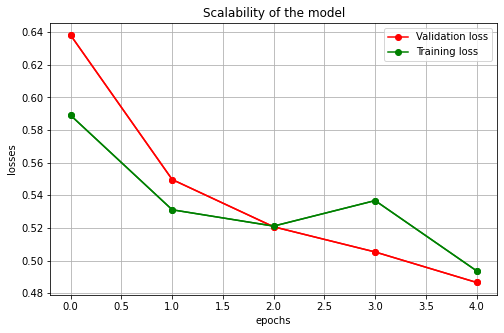

In [23]:
# ============
input_size = 100       # length is 100, given in Field
output_size = 1     
bidirectional = True
cell_type = 'GRU'
embedding_dim = 25
# =============================
hidden_size = 256     # number of hidden neurons
num_layers = 2        # number of layers
dropout = 0.0
clip_param = 1
# =============================
num_epochs = 5
LR = 0.01
loss_function = nn.BCELoss()
# ==============================

net = GRUclassifier(vocab.vectors, input_size, output_size,embedding_dim, hidden_size, num_layers, bidirectional,dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters

print(f"\nGRU model")
print("-----------------------------------------------------------------\n")
valid_losses,train_losses = trainNet(net,train_iter,valid_iter,num_epochs,clip_param)
acc, f1,recall,precision = testNet(net, test_iter)
FinalDf.loc[len(FinalDf)] = [cell_type,num_layers,hidden_size,'-',clip_param,dropout,acc,f1,recall,precision]
print("\n------------- Loss vs Epochs plot ---------------\n")
lossVSepoch(valid_losses,train_losses)

In [24]:
FinalDf

,Cell type,Layers of stacked RNNs,Hidden size of layers,Skip connections,gradient clipping,Dropout prob,Accuracy,F1-score,Recall-score,Precision
0,GRU,2,256,-,1,0.0,0.766021,0.762267,0.765629,0.766802


## **ROC-Curve** 
*This function is taken from a previous work done with a partner*

In [25]:
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from numpy import interp
from itertools import cycle

def create_ROCplot(n_classes,predictions,y_test,title):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    classes = [0,1]

    plt.figure(figsize=(8,5))
    plt.grid()
    

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(predictions))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2

    plt.plot(fpr["macro"],tpr["macro"],label='macro-average ROC curve ',
             color='green', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,lw=lw,label='Class - {0} '.format(classes[i]))

   
    plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
   
    plt.annotate('Random Guess',(.5,.48),color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title,fontsize=20,fontweight='bold')
    plt.legend(loc="lower right")
    plt.show()

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

batch_size = len(test_dataset)
rain_iter, valid_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, valid_dataset, test_dataset),
                                                          batch_sizes=(64,64,batch_size), sort=False,device = 'cuda' if train_on_gpu else 'cpu')

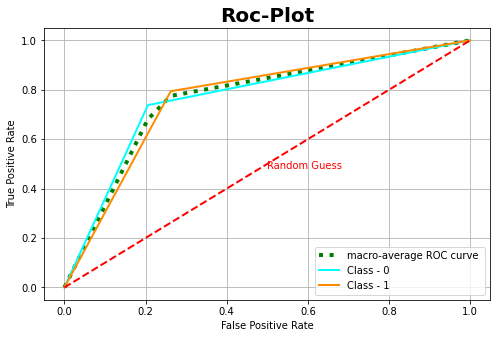

In [27]:
for batch in test_iter:

  if(train_on_gpu):
    batch.text, batch.target = batch.text.cuda(), batch.target.cuda()
    
  y_pred = predict(net,batch.text.T)
  y_pred = y_pred.cpu().detach().numpy().reshape(-1)
  y_test = batch.target.cpu().float()
  y_test = y_test.cpu().numpy()

  create_ROCplot(2,y_pred,y_test,'Roc-Plot')   

In [28]:
print(classification_report(y_test, y_pred,labels=np.unique(y_pred)))

              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76      2479
         1.0       0.75      0.79      0.77      2521

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



# Confusion Matrix

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.ylim([1.5, -.5])
    plt.show()

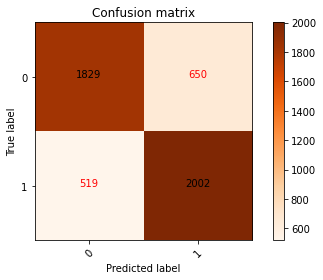

In [31]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=['0', '1'])

# **Remarks**



*   For this model we used GloVe for the pre-process, with vector size 25. RMS was chosen as an optimizer and BCELoss as loss function, because of the binary classification.
*   For neural network architecture:

> * The first layer is an Embedding layer, which matches the input vectors to the vocabulary vectors.
> * The second layer is a Linear hidden layer,which accepts as input size, the size of the features multiplied by the size of the GloVe vectors. It uses ReLU as activation function.
>* The output layer is Linear with input dimension  200 and output 1 with sigmoid as activation function.









## References



*   https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f


